# Colates, cleans and analyses canopy temperature data from Rain shelter barley trail

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as et
%matplotlib inline
import matplotlib.dates as mdates

from IPython.core.pylabtools import figsize
figsize(18, 5)

In [2]:
Data = pd.read_pickle('.\DataFrames\TempAndRadnCleaned.pkl')
Data.columns = Data.columns.droplevel(level=[3,4,5,6])
Data.sort_index(axis=1, inplace = True)
Data.sort_index(inplace = True)

In [3]:
Data.size / 1000000.0

5.392296

In [4]:
Cultivars = ['Dash','Omaka']
Irrigations = ['High','Low','Mid']
Ic = 0.8
Icl = 0.9
Cp = 1013 #Heat capacity of air Joule/kg/oC
Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28

In [5]:
TempDiff = Data.loc[:,'AirTemperature'].values - Data.loc[:,'IR_SurfaceTemp'] 
TempDiff = TempDiff * -1

In [6]:
treatments = pd.MultiIndex.from_product([['High','Mid','Low'],['Dash','Omaka']])

In [7]:
styleFrame = pd.DataFrame(index=treatments,columns=['Col','Lin'],
            data =[('b','--'),('b','-'),('g','--'),('g','-'),('r','--'),('r','-')] )
styleFrame

Col Lin
High Dash    b  --
     Omaka   b   -
Mid  Dash    g  --
     Omaka   g   -
Low  Dash    r  --
     Omaka   r   -

In [8]:
TreatCombs = list(zip(TempDiff.columns.get_level_values(1),TempDiff.columns.get_level_values(0)))
TreatCombs

[('High', 'Dash'),
 ('High', 'Dash'),
 ('High', 'Dash'),
 ('High', 'Dash'),
 ('Low', 'Dash'),
 ('Low', 'Dash'),
 ('Low', 'Dash'),
 ('Low', 'Dash'),
 ('Mid', 'Dash'),
 ('Mid', 'Dash'),
 ('Mid', 'Dash'),
 ('Mid', 'Dash'),
 ('High', 'Omaka'),
 ('High', 'Omaka'),
 ('High', 'Omaka'),
 ('High', 'Omaka'),
 ('Low', 'Omaka'),
 ('Low', 'Omaka'),
 ('Low', 'Omaka'),
 ('Low', 'Omaka'),
 ('Mid', 'Omaka'),
 ('Mid', 'Omaka'),
 ('Mid', 'Omaka'),
 ('Mid', 'Omaka')]

In [9]:
colorCycle = [styleFrame.loc[x,'Col'] for x in TreatCombs]
print(colorCycle)
lineCycle = [styleFrame.loc[x,'Lin'] for x in TreatCombs]
print(lineCycle)

['b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'g', 'g', 'g', 'g', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'g', 'g', 'g', 'g']
['--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']


## Look at treatment patterns of surface temp differential

## There are nice treatment and daily differences, how do they look within days

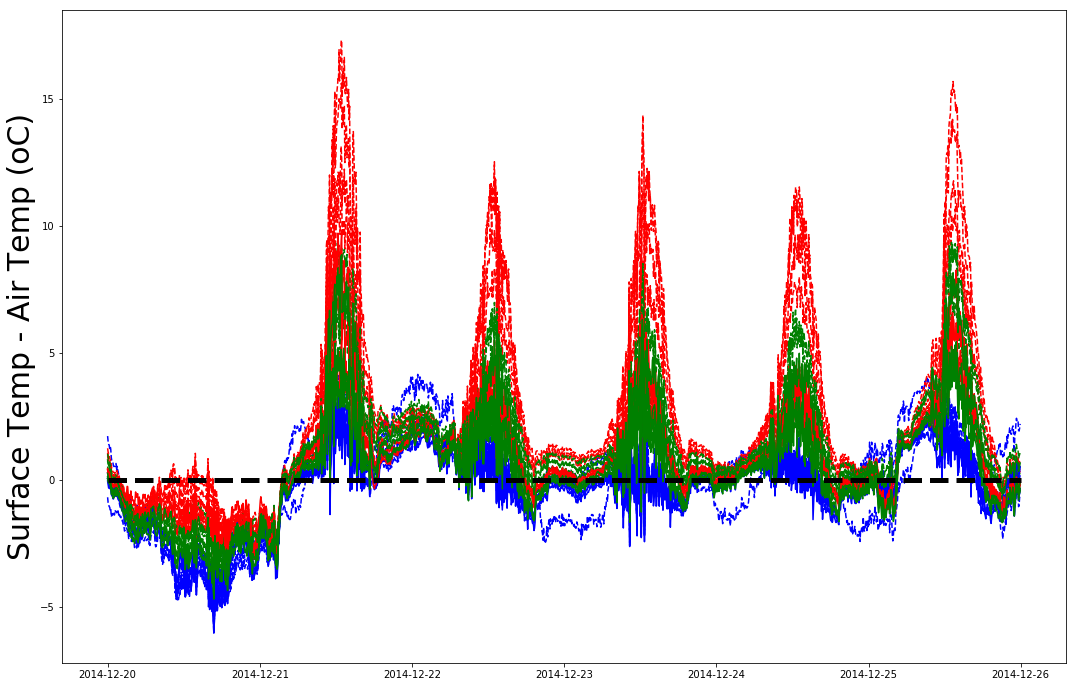

In [10]:
Figure = plt.figure(figsize=(18, 12))
ax = Figure.add_subplot(1,1,1)
ax.set_prop_cycle(color=colorCycle, linestyle=lineCycle)
plt.plot(TempDiff.loc['2014-12-20':'2014-12-25'])
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.plot(pd.to_datetime(['2014-12-20','2014-12-26']),[0,0], c='k', linewidth=5)

### The temperature differences are comming mostly during the day time but they are non zero at night and some treatment differences remain so will will remove the night time data from our daily means

## Set up a mask for day-light hours and filter out all data after dark

### First look at the radiation data

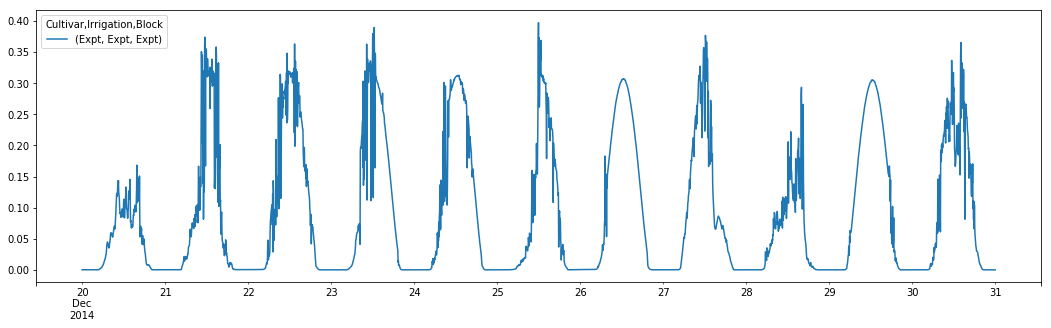

In [11]:
Data.IncomingRadnMJ.loc['2014-12-20':'2014-12-30'].plot(figsize=(18,5))

### Values less that 0.002 MJ/h can be treated as dark

### Create a tuple of the time stamps that have radiation > 0.002 MJ/h

In [12]:
DaylightIndex = Data.IncomingRadnMJ.where(Data.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()

### Create temperature dataframes with daylight data

In [13]:
DayTimeTempDiff = TempDiff.loc[DaylightIndex,:]

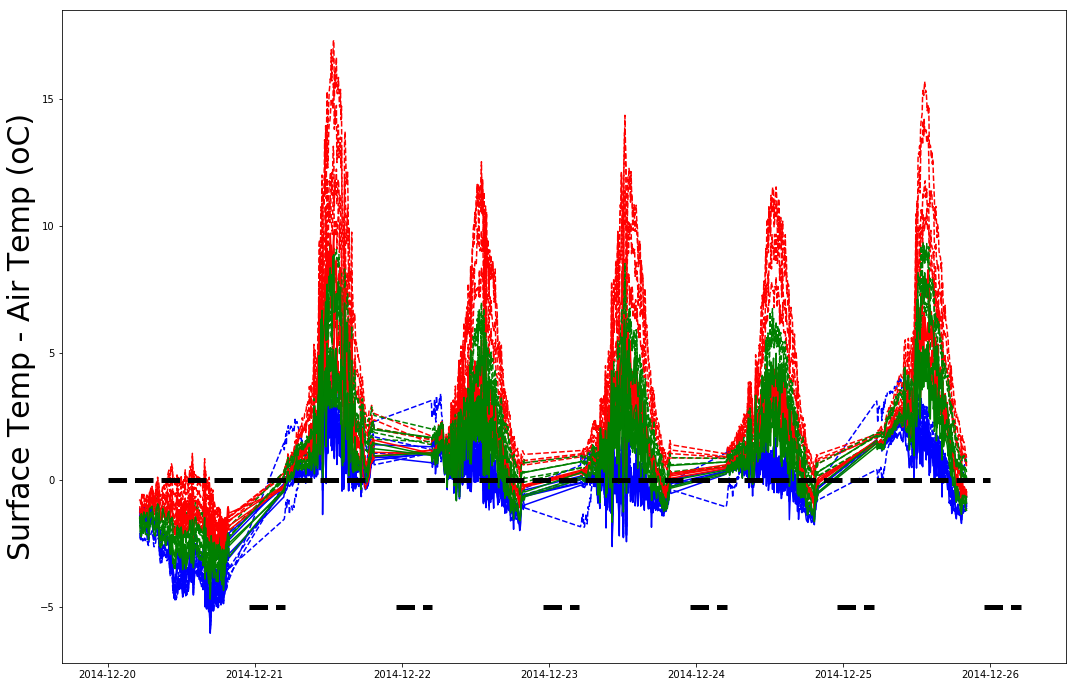

In [14]:
Figure = plt.figure(figsize=(18, 12))
ax = Figure.add_subplot(1,1,1)
ax.set_prop_cycle(color=colorCycle, linestyle=lineCycle)
plt.plot(DayTimeTempDiff.loc['2014-12-20':'2014-12-25'])
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.plot(pd.to_datetime(['2014-12-20','2014-12-26']),[0,0], c='k', linewidth=5)
plt.plot(pd.to_datetime(['2014-12-20 23:00','2014-12-21 5:00']),[-5,-5], c='k', linewidth=5)
plt.plot(pd.to_datetime(['2014-12-21 23:00','2014-12-22 5:00']),[-5,-5], c='k', linewidth=5)
plt.plot(pd.to_datetime(['2014-12-22 23:00','2014-12-23 5:00']),[-5,-5], c='k', linewidth=5)
plt.plot(pd.to_datetime(['2014-12-23 23:00','2014-12-24 5:00']),[-5,-5], c='k', linewidth=5)
plt.plot(pd.to_datetime(['2014-12-24 23:00','2014-12-25 5:00']),[-5,-5], c='k', linewidth=5)
plt.plot(pd.to_datetime(['2014-12-25 23:00','2014-12-26 5:00']),[-5,-5], c='k', linewidth=5)

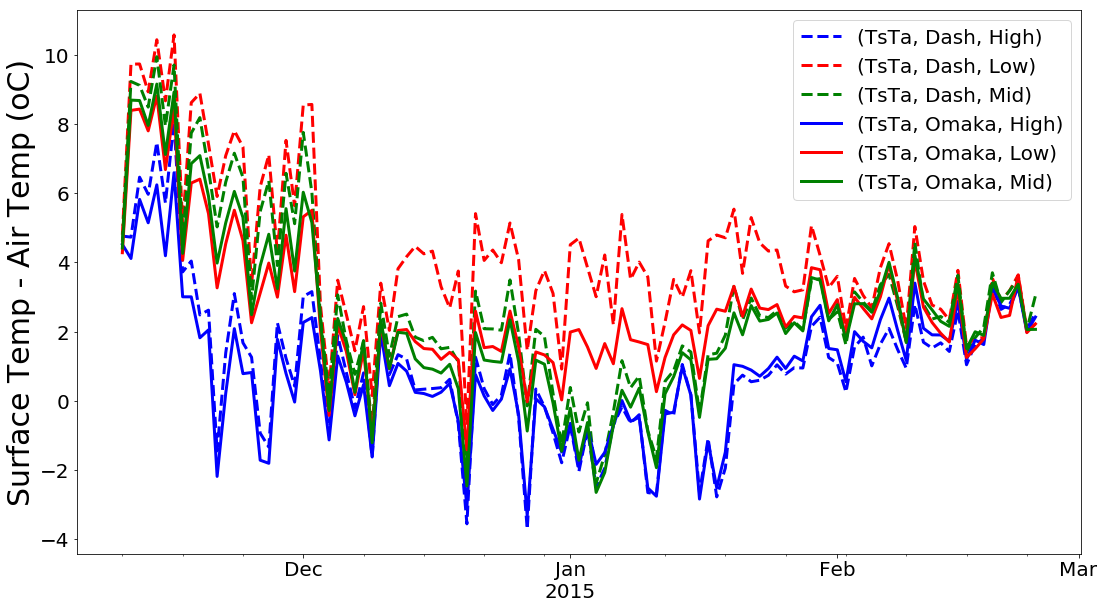

In [15]:
#Agregate data
DayTimeMeanTempDiff = DayTimeTempDiff.resample('D').mean()
DayTimeMeanTempDiff = DayTimeMeanTempDiff.groupby(level=['Cultivar','Irrigation'],axis=1).mean()
#Make index inculding measurement lable
tup = ['TsTa']
NewIndex = pd.MultiIndex.from_product([tup,Cultivars,Irrigations],names=['Measurement','Cultivar','Irrigation'])
#Attach new index to data frame
DayTimeMeanTempDiff.columns = NewIndex
#graph
DayTimeMeanTempDiff.loc['2014-11-10':,:].plot(fontsize = 20,figsize=(18,10), style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Surface Temp - Air Temp (oC)', fontsize=30);
plt.legend(fontsize=20)

In [16]:
LowIrrIndex = pd.to_datetime('2014-12-02 00:00:00')
MidIrrIndex = pd.to_datetime(['2014-12-02 00:00:00','2014-12-23 00:00:00'])
HighIrrigIndex = pd.to_datetime(['2014-11-11 00:00:00',
 '2014-11-18 00:00:00',
 '2014-11-26 00:00:00',
 '2014-12-02 00:00:00',
 '2014-12-10 00:00:00',
 '2014-12-16 00:00:00',
 '2014-12-23 00:00:00',
 '2014-12-30 00:00:00',
 '2015-01-06 00:00:00',
 '2015-01-14 00:00:00'])

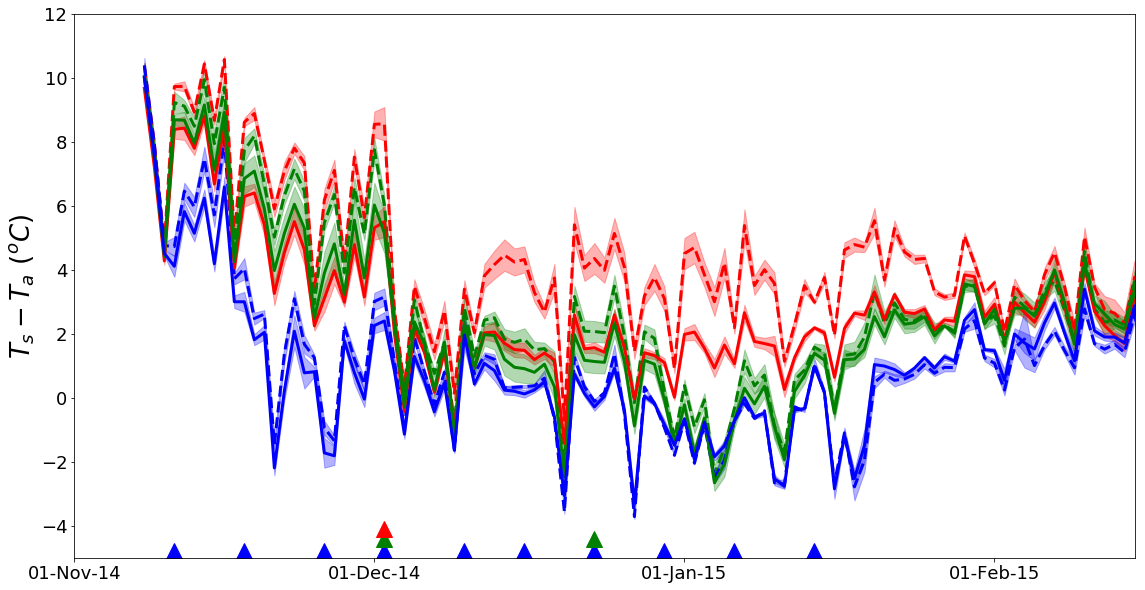

In [17]:
Graph = plt.figure(figsize=(19,10))
fig = Graph.add_subplot(1,1,1)
Cultivars = ['Dash','Omaka']
Irrigations = ['Low','Mid','High']
colors = ['r','g','b']
cultColors = ['w','w','r','b']
irrigColors = ['r','g','b','r','g','b']
cultLines = ['--','--','--','-','-','-']
alphas = [0.2,0.3]

TsTaData = DayTimeTempDiff.loc['2014-11-7':].resample('d').mean()
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = TsTaData.loc[:,(Cul,Irr)].index
        Med = TsTaData.loc[:,(Cul,Irr)].mean(axis=1)
        SEM = TsTaData.loc[:,(Cul,Irr)].std(axis=1)/np.sqrt(3)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = colors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,cultLines[CulPos],color=irrigColors[IrrPos],label = Cul + ' ' + Irr, linewidth=3)
        IrrPos += 1
        CulPos+=1
plt.xlim('2014-11-1','2015-02-15')
plt.ylim(-5,12)
plt.ylabel('$T_s - T_a$ $(^oC)$', fontsize=26, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=18)    
plt.plot(HighIrrigIndex,list(-4.8 for x in range(len(HighIrrigIndex))),'^',c='b',markersize=16)
plt.plot(MidIrrIndex,[-4.4,-4.4],'^',c='g',markersize=16)
plt.plot(LowIrrIndex,[-4.1],'^',c='r',markersize=16)

In [18]:
DayTimeMeanTempDiff.to_pickle('.\DataFrames\DayTimeMeanSurfaceTemp.pkl')

# Calculate additional variables

## Aerodynamic resistance (Ra)

In [19]:
Data.loc[:,('Ra','Expt', 'Expt','Expt')] = [et.Ra(Data.loc[x,'Windspeed'].values[0],1.2, 0.5) for x in Data.index]

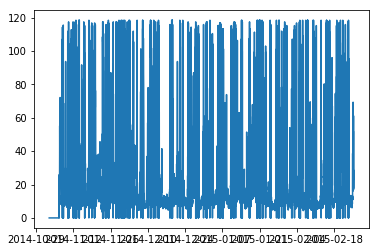

In [20]:
plt.plot(Data.Ra)

## Saturated Vapor pressure (SatVP)

In [21]:
#Function returns SatVP in mbar.  Divide by 10 to convert to kPa
Data.loc[:,('SatVP','Expt', 'Expt','Expt')] = [et.saturated_vapor_pressure(Data.loc[x,'AirTemperature'].values[0])/10 for x in Data.index]

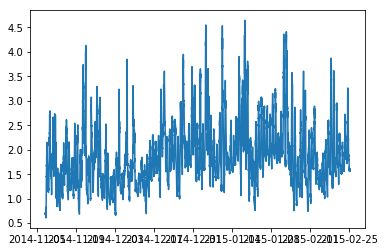

In [22]:
plt.plot(Data.SatVP)

## Vapor pressure (VP)

In [23]:
Data.loc[:,('VP', 'Expt', 'Expt','Expt')] = [Data.loc[x,'SatVP'].values[0] * Data.loc[x,'RelativeHumidity'].values[0]/100 for x in Data.index]

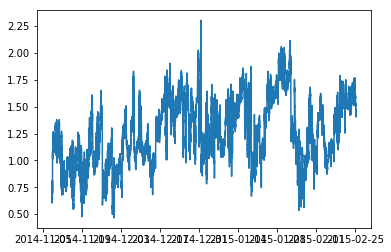

In [24]:
plt.plot(Data.VP)

## Vapor pressure deficit (VPD)

In [25]:
Data.loc[:,('VPD', 'Expt', 'Expt','Expt')] = [Data.loc[x,'SatVP'].values[0] - Data.loc[x,'VP'].values[0] for x in Data.index]

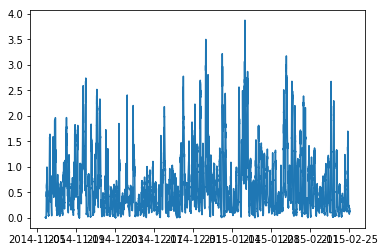

In [26]:
plt.plot(Data.VPD)

Text(0.5,0,'Air Temperature oC')

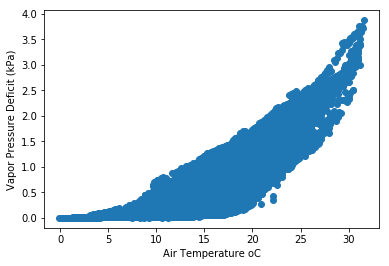

In [27]:
plt.plot (Data.AirTemperature, Data.VPD,'o')
plt.ylabel('Vapor Pressure Deficit (kPa)')
plt.xlabel('Air Temperature oC')

### VPD response to temperature is showing the sort of exponential relationship we would expect

## AirDensity (q)

In [28]:
Data.loc[:,('q','Expt','Expt','Expt')] = [et.AirDensity(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

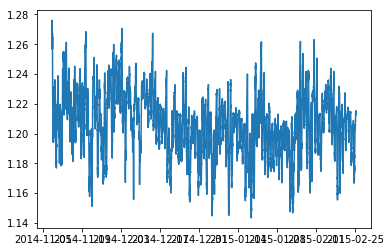

In [29]:
plt.plot(Data.q)

## Phycometric constant (gamma)

In [30]:
Data.loc[:,('gamma','Expt','Expt','Expt')] = [et.gama(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

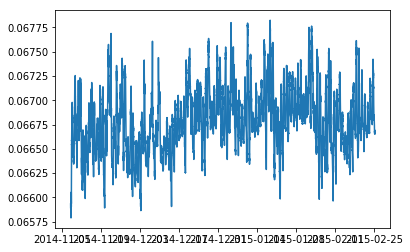

In [31]:
plt.plot(Data.gamma)

## Slope of the satruarted vapour pressure curve (delta)

In [32]:
Data.loc[:,('delta','Expt','Expt','Expt')] = [et.saturated_vapor_pressure_slope(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

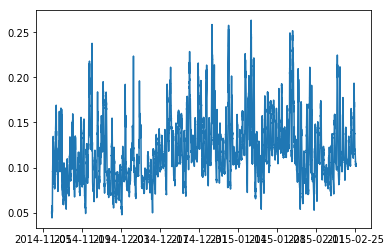

In [33]:
plt.plot(Data.delta)

# latent heat of vaporisation (lamda)

In [34]:
Data.loc[:,('lamda','Expt','Expt','Expt')] = [et.lamda(Data.loc[x,'AirTemperature'].values[0]) for x in Data.index]

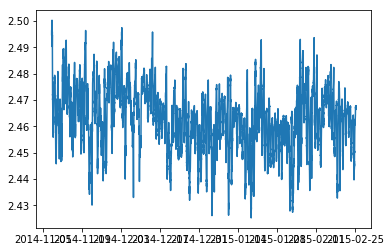

In [35]:
plt.plot(Data.lamda)

## Duration (in hours)

In [36]:
def calcPeriod(End, Start):
    durat = End - Start
    secs = float(durat.seconds)
    _ret = secs/3600
    return _ret
    

In [37]:
Data.loc[:,('Duration','Expt','Expt','Expt')] = [calcPeriod(Data.index[x],Data.index[x-1]) for x in range(Data.index.size)]

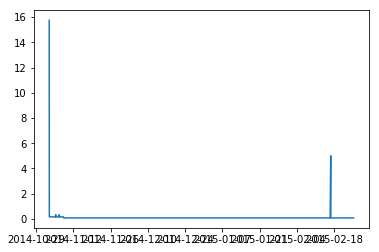

In [38]:
plt.plot(Data.Duration)

## Time (in decimal hour scale, 0-24)

In [39]:
def calcTime(DateTimeOfInterest):
    When = DateTimeOfInterest.to_pydatetime()
    zerohour =  datetime.datetime(When.year, When.month, When.day, 0, 0)
    _hour = When - zerohour
    Hour = float(_hour.seconds)/3600
    _ret = 0
    if Hour >1:
        _ret = Hour-1
    else:
        _ret = 23 + Hour
    return _ret

In [40]:
Data.loc[:,('Time','Expt','Expt','Expt')] = [calcTime(Data.index[x]) for x in range(Data.index.size)]

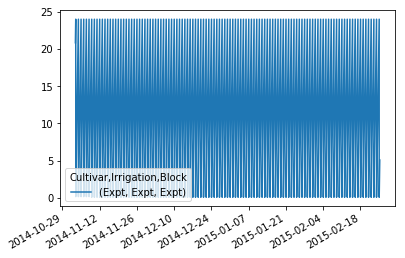

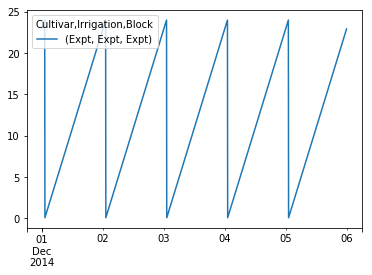

In [41]:
Data.Time.plot()
Data.Time.loc['2014-12-1':'2014-12-5'].plot()

## Day of Year (DOY)

In [42]:
Data.loc[:,('DOY','Expt','Expt','Expt')] = [Data.index[x].dayofyear for x in range(Data.index.size)]

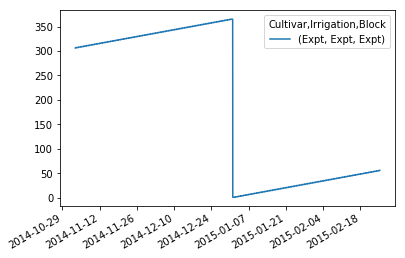

In [43]:
Data.DOY.plot()

## Extrateresteral radiation (Rex)

In [44]:
Data.loc[:,('Rex','Expt','Expt','Expt')] = [et.ExtraterestialRadiation(Lattitude,
                               Data.loc[x,'DOY'].values[0],
                               Data.loc[x,'Duration'].values[0],
                               Data.loc[x,'Time'].values[0],
                               LongitudeTZ,
                               LongitudeML) for x in Data.index]

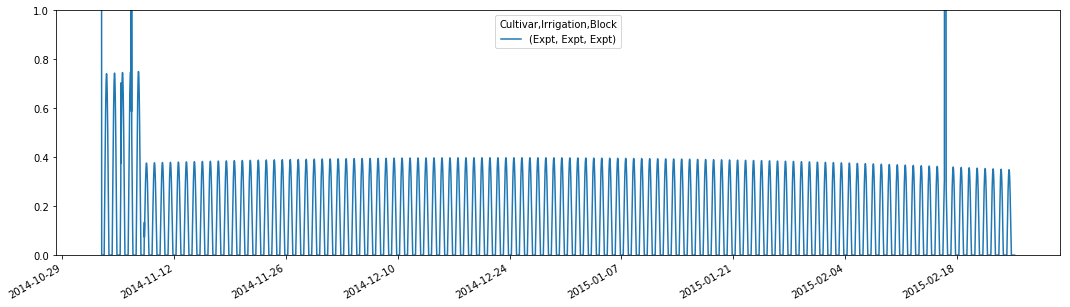

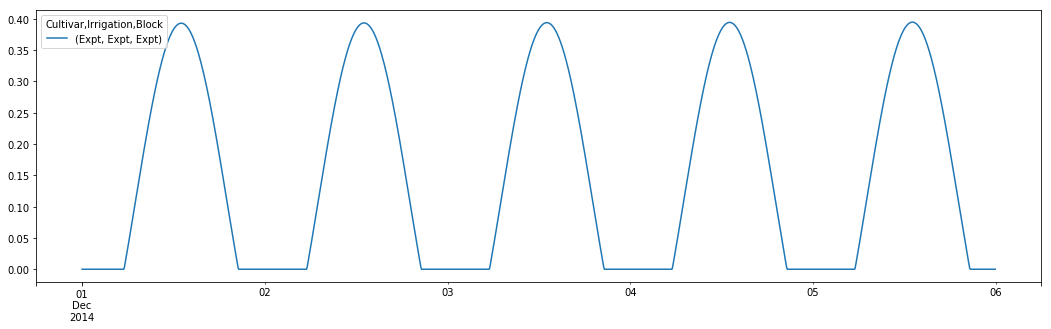

In [45]:
Data.Rex.plot(figsize = (18,5),ylim=(0,1))
Data.Rex.loc['2014-12-1':'2014-12-5'].plot(figsize = (18,5))

## Clear sky radiation (So)

In [46]:
Data.loc[:,('So','Expt','Expt','Expt')] = [et.ClearSkyRadiation(Lattitude,
                               Data.loc[x,'DOY'].values[0],
                               Data.loc[x,'Duration'].values[0],
                               Data.loc[x,'Time'].values[0],
                               LongitudeTZ,
                               LongitudeML) for x in Data.index]

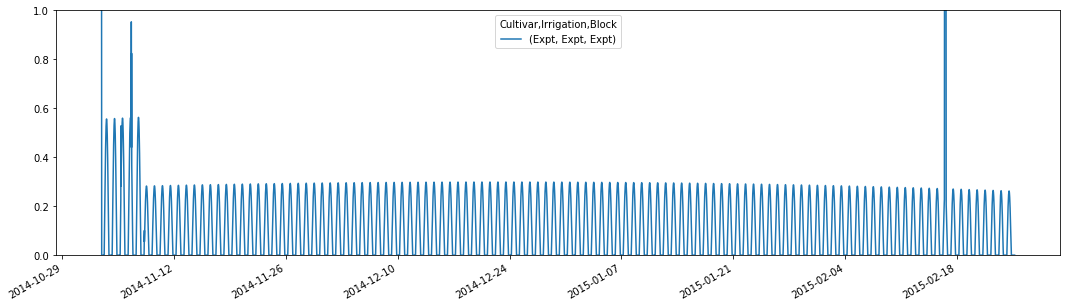

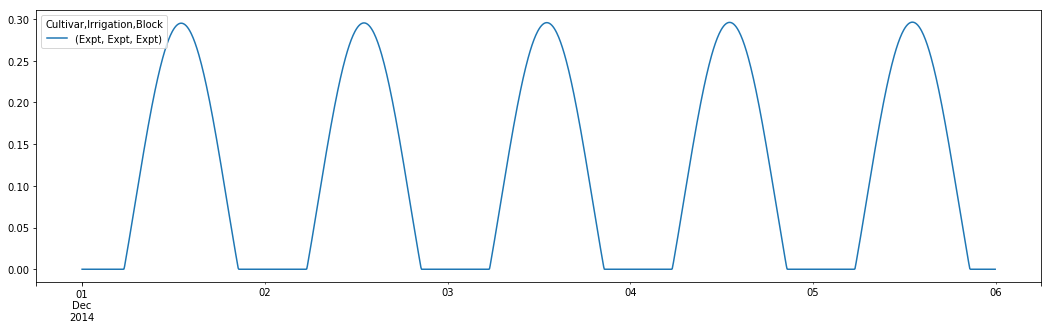

In [47]:
Data.So.plot(figsize = (18,5),ylim=(0,1))
Data.So.loc['2014-12-1':'2014-12-5'].plot(figsize = (18,5))

## Nett Radiation (Rn)

### Calculation Net radiation in MJ/m2

### Bring in plot specific albedo data

In [56]:
Data.loc[:,('RnMJ','Expt','Expt','Expt')] = [et.NetRadiation(Data.loc[x,'IncomingRadnMJ'].values[0],
                              Data.loc[x,'AirTemperature'].values[0],
                              Data.loc[x,'VP'].values[0],
                              Lattitude,
                              Data.loc[x,'DOY'].values[0],
                              Data.loc[x,'Duration'].values[0],
                              Data.loc[x,'Time'].values[0],
                              LongitudeTZ,
                              LongitudeML,
                              Albedo) for x in Data.index]

In [ ]:
Data.RnMJ.plot(figsize = (18,5),ylim=(0,0.4))
Data.RnMJ.loc['2014-12-1':'2014-12-5'].plot(figsize = (18,5))

In [ ]:
plt.scatter(Data.IncomingRadnMJ.resample('D').sum(),
Data.RnMJ.resample('D').sum())
plt.plot([0,30],[0,20],'-')
plt.text(0.1,20,'Slope = 0.66')

In [57]:
Broadfields = pd.read_pickle('.\DataFrames\BroadFieldsDaily.pkl')

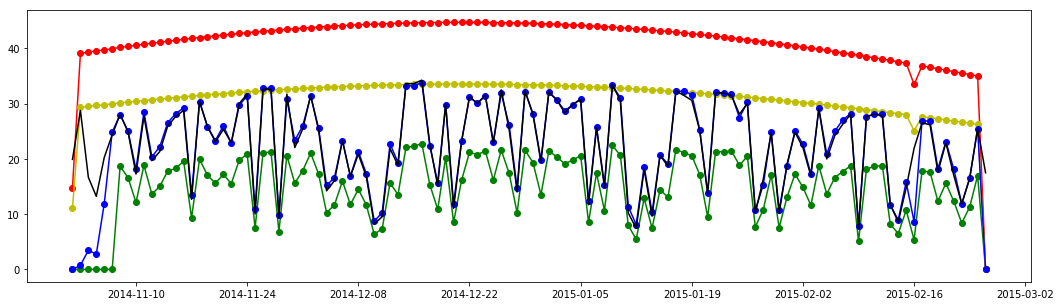

In [61]:
figure = plt.figure(figsize=(18,5))
plt.plot(Data.RnMJ.resample('D').sum(),'-o',color='g')
plt.plot(Data.Rex.resample('D').sum(),'-o',color='r')
plt.plot(Data.So.resample('D').sum(),'-o',color='y')
plt.plot(Data.IncomingRadnMJ.resample('D').sum(),'-o',color='b')
plt.plot(Broadfields.IncomingRadnMJ.loc['2014-11-02':'2015-02-25'], color = 'k')

### Net radiation data all looks good

### Convert to W/m2 by dividing by the period duration in seconds

In [62]:
def calcRnW(RnMJseries,DurationSeries):
    Return = []
    for x in RnMJseries.index:
        if DurationSeries.loc[x][0] == 0:
            Return.append(0)
        else:
            Return.append((RnMJseries.loc[x][0]*1000000)/(DurationSeries.loc[x][0]*3600)) #Multiply by a million to convert to jouls and by 3600 to convert from hours to seconds
    return Return    

In [63]:
Data[('RnW','Expt','Expt','Expt')] = calcRnW(Data.loc[:,'RnMJ'],Data.loc[:,'Duration'])

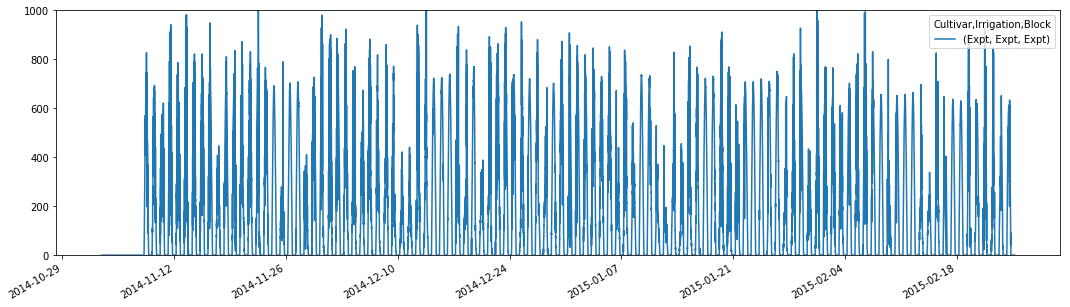

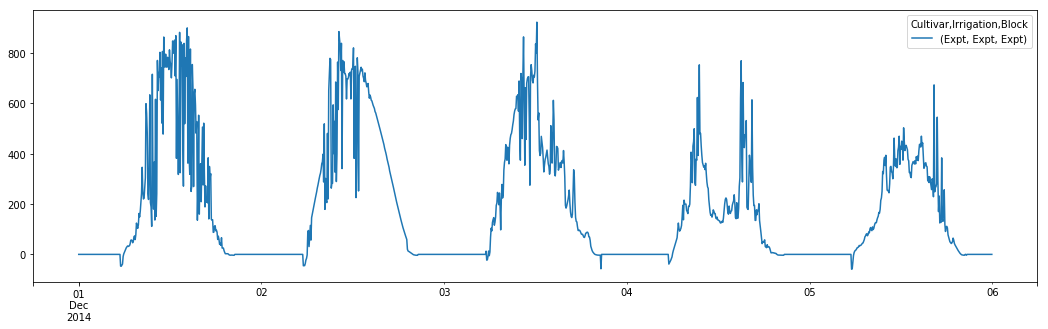

In [64]:
Data.RnW.plot(figsize = (18,5),ylim=(0,1000))
Data.RnW.loc['2014-12-1':'2014-12-5'].plot(figsize = (18,5))

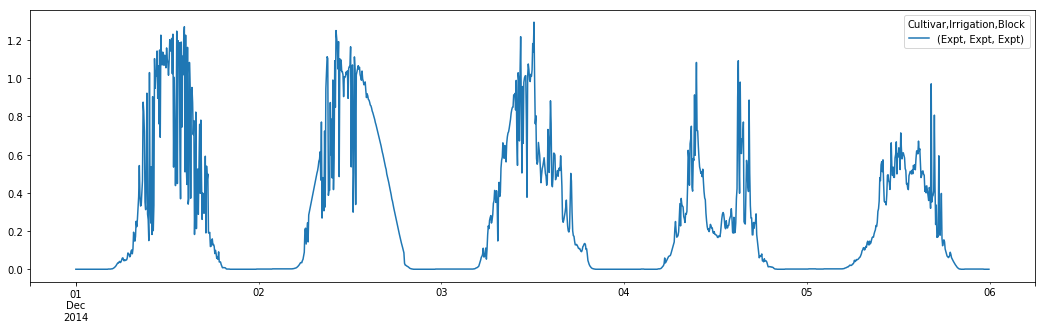

In [65]:
Data.IncomingRadnKW.loc['2014-12-1':'2014-12-5'].plot(figsize=(18,5))

### Instanious net radiation data looks sensible

In [66]:
Data.to_pickle('.\DataFrames\TempAndMet.pkl')